## Imports

In [1]:
import json
import os
import os.path as osp
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apxinfer.core.model import XIPModel
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score
from willump.evaluation.willump_executor import willump_execute


## Task Specifics (Specific)

In [2]:
from apxinfer.examples.machinery.trainer import MachineryTrainer
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('-t', '--task_name')
parser.add_argument('-s', '--seed', type=int)
args = parser.parse_args()

working_dir = os.getcwd()
experiment_path = "experiment-results" # change to your own
task_name = args.task_name if args.task_name else "machinery"
model_name = "mlp"
model_file = "mlp.pkl"
preparation_rescale = 1
if working_dir == '/home/ckchang/Biathlon/willump-adaptation':
  os.chdir('..')
assert working_dir == '/home/ckchang/Biathlon'
working_dir = os.getcwd()

## Model Training Parameters

In [3]:

# model arguments
seed = args.seed if args.seed else 0
scaler_type = None
multi_class = False


## Loading Model, Data and Feature

In [4]:

# read in the model
original_model = joblib.load(osp.join(working_dir, experiment_path, task_name, "model", model_file))

# read the dataset
train_set = pd.read_csv(osp.join(working_dir, experiment_path, task_name, "dataset", "train_set.csv"))
test_set = pd.read_csv(osp.join(working_dir, experiment_path, task_name, "dataset", "test_set.csv"))
num_rows = len(test_set)


cols = list(train_set.columns)
fnames = [col for col in cols if col.startswith("f_")]
label_name = cols[-1]

def read_feature_info():
  # read in the feature info
  qcosts = json.load(open(osp.join(working_dir, experiment_path, task_name, "qcosts.json"), "r"))
  num_reqs = qcosts["nreqs"]
  group_costs = qcosts["qcosts"]
  return (num_reqs, group_costs)

num_reqs, group_costs = read_feature_info()
num_groups = len(group_costs)
num_reqs *= preparation_rescale

## Willump Registration Functions (Specific)

In [5]:
# training
def willump_train(y, X_list):
  X = np.concatenate(X_list, axis=1)
  # X = pd.concat(X_list, axis=1)
  trainer = MachineryTrainer(
    working_dir,
    original_model.model_type,
    model_name,
    seed,
    scaler_type,
    multi_class,
  )
  model = trainer.build_model(X, y)
  return model


def willump_predict(model, X_list):
  X = np.concatenate(X_list, axis=1)
  # X = pd.concat(X_list, axis=1)
  if X.shape[0] == 0:
    return np.zeros(0, dtype=np.int64)
  else:
    return model.predict(X)


def willump_confidence(model: XIPModel, X_list):
  X = np.concatenate(X_list, axis=1)
  # X = pd.concat(X_list, axis=1)
  return model.predict_proba(X)[:, 1]


def willump_score(true_y, pred_y):
  return roc_auc_score(true_y, pred_y)



### Generated Transformation Functions

In [6]:

def pseudo_transform_function0(input_x):
  time.sleep(group_costs[0] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-0")]].to_numpy()

def pseudo_transform_function1(input_x):
  time.sleep(group_costs[1] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-1")]].to_numpy()

def pseudo_transform_function2(input_x):
  time.sleep(group_costs[2] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-2")]].to_numpy()

def pseudo_transform_function3(input_x):
  time.sleep(group_costs[3] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-3")]].to_numpy()

def pseudo_transform_function4(input_x):
  time.sleep(group_costs[4] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-4")]].to_numpy()

def pseudo_transform_function5(input_x):
  time.sleep(group_costs[5] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-5")]].to_numpy()

def pseudo_transform_function6(input_x):
  time.sleep(group_costs[6] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-6")]].to_numpy()

def pseudo_transform_function7(input_x):
  time.sleep(group_costs[7] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q-7")]].to_numpy()


cascades_dict = {}
@willump_execute(
  train_function=willump_train,
  predict_function=willump_predict,
  confidence_function=willump_confidence,
  score_function=willump_score,
  train_cascades_params=cascades_dict,
)
def willump_train_pipeline(input_x, input_y):
  feature0 = pseudo_transform_function0(input_x)
  feature1 = pseudo_transform_function1(input_x)
  feature2 = pseudo_transform_function2(input_x)
  feature3 = pseudo_transform_function3(input_x)
  feature4 = pseudo_transform_function4(input_x)
  feature5 = pseudo_transform_function5(input_x)
  feature6 = pseudo_transform_function6(input_x)
  feature7 = pseudo_transform_function7(input_x)
  return willump_train(input_y, [feature0, feature1, feature2, feature3, feature4, feature5, feature6, feature7])



## Training with Willump

In [7]:
start_time = time.time()
willump_train_pipeline(train_set[fnames], train_set[label_name].to_numpy())
print("Elapsed time: ", time.time() - start_time)
print("Cascades dict contents:", cascades_dict)

start_time = time.time()
willump_model = willump_train_pipeline(train_set[fnames], train_set[label_name].to_numpy())
print("Elapsed time: ", time.time() - start_time)
print("Cascades dict contents:", cascades_dict)


INFO:XIPTrainer:Building pipeline for classifier mlp


Iteration 1, loss = 0.50244800
Iteration 2, loss = 0.42313782
Iteration 3, loss = 0.39192022
Iteration 4, loss = 0.39053879
Iteration 5, loss = 0.37891466
Iteration 6, loss = 0.37136714
Iteration 7, loss = 0.36415600
Iteration 8, loss = 0.35734727
Iteration 9, loss = 0.35106892
Iteration 10, loss = 0.34578756
Iteration 11, loss = 0.34144043
Iteration 12, loss = 0.33792539
Iteration 13, loss = 0.33208921
Iteration 14, loss = 0.32739740
Iteration 15, loss = 0.33031342
Iteration 16, loss = 0.32263924
Iteration 17, loss = 0.31072668
Iteration 18, loss = 0.30865903
Iteration 19, loss = 0.30033541
Iteration 20, loss = 0.29301416
Iteration 21, loss = 0.28967282
Iteration 22, loss = 0.28106459
Iteration 23, loss = 0.27392709
Iteration 24, loss = 0.26799330
Iteration 25, loss = 0.26342405
Iteration 26, loss = 0.26075240
Iteration 27, loss = 0.25089508
Iteration 28, loss = 0.24655021
Iteration 29, loss = 0.24764836
Iteration 30, loss = 0.23692514
Iteration 31, loss = 0.23241229
Iteration 32, los

INFO:XIPTrainer:Building pipeline for classifier mlp


Iteration 90, loss = 0.12855668
Iteration 91, loss = 0.13486044
Iteration 92, loss = 0.13850338
Iteration 93, loss = 0.13742446
Iteration 94, loss = 0.13707820
Iteration 95, loss = 0.13648540
Iteration 96, loss = 0.13412583
Iteration 97, loss = 0.14644578
Iteration 98, loss = 0.12972039
Iteration 99, loss = 0.13043967
Iteration 100, loss = 0.13461856
Iteration 101, loss = 0.13359765
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Elapsed time:  43.90797019004822
Cascades dict contents: {}
Iteration 1, loss = 0.54159787
Iteration 2, loss = 0.44074113
Iteration 3, loss = 0.42788481
Iteration 4, loss = 0.42112818
Iteration 5, loss = 0.41975540
Iteration 6, loss = 0.41233323
Iteration 7, loss = 0.40699552
Iteration 8, loss = 0.39807439
Iteration 9, loss = 0.39610173
Iteration 10, loss = 0.38877794
Iteration 11, loss = 0.37994054
Iteration 12, loss = 0.37612635
Iteration 13, loss = 0.36835692
Iteration 14, loss = 0.36209747
Iteration 15, loss = 0.35

INFO:XIPTrainer:Building pipeline for classifier mlp


Iteration 186, loss = 0.14657395
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Feature: feature4                  Cost:  5.379 Importance:  0.352
Feature: feature6                  Cost:  5.384 Importance:  0.101
Feature: feature2                  Cost:  5.286 Importance:  0.000
Feature: feature3                  Cost:  5.300 Importance:  0.000
Feature: feature7                  Cost:  5.407 Importance:  0.000
Feature: feature1                  Cost:  5.293 Importance: -0.003
Feature: feature0                  Cost:  5.433 Importance: -0.024
Feature: feature5                  Cost:  5.468 Importance: -0.024
Iteration 1, loss = 0.55113541
Iteration 2, loss = 0.44071578
Iteration 3, loss = 0.43526072
Iteration 4, loss = 0.42804448
Iteration 5, loss = 0.43079974
Iteration 6, loss = 0.42359018
Iteration 7, loss = 0.42337651
Iteration 8, loss = 0.42095217
Iteration 9, loss = 0.41884000
Iteration 10, loss = 0.41684125
Iteration 11, loss = 0.4142080

INFO:XIPTrainer:Building pipeline for classifier mlp


Iteration 53, loss = 0.23993066
Iteration 54, loss = 0.23782008
Iteration 55, loss = 0.23745805
Iteration 56, loss = 0.23742571
Iteration 57, loss = 0.23691023
Iteration 58, loss = 0.23678463
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Cutoff: 0.200000 Threshold: 0.900000 Expected Cost: 11.077137
Iteration 1, loss = 0.57665367
Iteration 2, loss = 0.42816271
Iteration 3, loss = 0.45017545
Iteration 4, loss = 0.41728918
Iteration 5, loss = 0.41031631
Iteration 6, loss = 0.40409114
Iteration 7, loss = 0.39581367
Iteration 8, loss = 0.38965062
Iteration 9, loss = 0.38480786
Iteration 10, loss = 0.37654546
Iteration 11, loss = 0.37609886
Iteration 12, loss = 0.36843554
Iteration 13, loss = 0.36914122
Iteration 14, loss = 0.36368009
Iteration 15, loss = 0.36289673
Iteration 16, loss = 0.36328087
Iteration 17, loss = 0.35782953
Iteration 18, loss = 0.35798682
Iteration 19, loss = 0.35409598
Iteration 20, loss = 0.35358938
Iteration 21, loss = 0.34

INFO:XIPTrainer:Building pipeline for classifier mlp


Iteration 69, loss = 0.16779189
Iteration 70, loss = 0.16722036
Iteration 71, loss = 0.16529887
Iteration 72, loss = 0.17103251
Iteration 73, loss = 0.16679559
Iteration 74, loss = 0.16324884
Iteration 75, loss = 0.16894265
Iteration 76, loss = 0.16775506
Iteration 77, loss = 0.16582041
Iteration 78, loss = 0.17031008
Iteration 79, loss = 0.17404549
Iteration 80, loss = 0.16465510
Iteration 81, loss = 0.17922596
Iteration 82, loss = 0.17882659
Iteration 83, loss = 0.16825489
Iteration 84, loss = 0.17774831
Iteration 85, loss = 0.16637988
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Cutoff: 0.300000 Threshold: 0.600000 Expected Cost: 10.915670
Iteration 1, loss = 0.50244800
Iteration 2, loss = 0.42313782
Iteration 3, loss = 0.39192022
Iteration 4, loss = 0.39053879
Iteration 5, loss = 0.37891466
Iteration 6, loss = 0.37136714
Iteration 7, loss = 0.36415600
Iteration 8, loss = 0.35734727
Iteration 9, loss = 0.35106892
Iteration 10, loss = 0.34

INFO:XIPTrainer:Building pipeline for classifier mlp


Iteration 100, loss = 0.13461856
Iteration 101, loss = 0.13359765
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.54571236
Iteration 2, loss = 0.41487707
Iteration 3, loss = 0.40028329
Iteration 4, loss = 0.39455943
Iteration 5, loss = 0.38098835
Iteration 6, loss = 0.38100506
Iteration 7, loss = 0.36731742
Iteration 8, loss = 0.36250031
Iteration 9, loss = 0.35414268
Iteration 10, loss = 0.34929268
Iteration 11, loss = 0.34498778
Iteration 12, loss = 0.34186210
Iteration 13, loss = 0.33946060
Iteration 14, loss = 0.33919386
Iteration 15, loss = 0.33337129
Iteration 16, loss = 0.32954632
Iteration 17, loss = 0.33090038
Iteration 18, loss = 0.31987716
Iteration 19, loss = 0.31889719
Iteration 20, loss = 0.30531077
Iteration 21, loss = 0.30115495
Iteration 22, loss = 0.29423286
Iteration 23, loss = 0.28003530
Iteration 24, loss = 0.27865219
Iteration 25, loss = 0.26057276
Iteration 26, loss = 0.24907113
Iteration 27, loss = 

## Evaluation

In [8]:

result_dict = {"baseline": {}, "willump": {}, "preparation_rescale": preparation_rescale}

### Baseline (Specific)

In [9]:

## baseline
def willump_eval_pipeline(input_x, model):
  feature0 = pseudo_transform_function0(input_x)
  feature1 = pseudo_transform_function1(input_x)
  feature2 = pseudo_transform_function2(input_x)
  feature3 = pseudo_transform_function3(input_x)
  feature4 = pseudo_transform_function4(input_x)
  feature5 = pseudo_transform_function5(input_x)
  feature6 = pseudo_transform_function6(input_x)
  feature7 = pseudo_transform_function7(input_x)
  return willump_predict(model, [feature0, feature1, feature2, feature3, feature4, feature5, feature6, feature7])

unopt_time_elapsed_total = 0
result_dict["baseline"]["latency"] = []
baseline_preds = np.zeros(num_rows)

for i in range(num_rows):
  entry = test_set.iloc[i:i+1]
  time_start = time.time()
  preds = willump_eval_pipeline(entry, willump_model)
  time_elapsed = time.time() - time_start
  result_dict["baseline"]["latency"].append(time_elapsed)
  baseline_preds[i] = preds[0]
  unopt_time_elapsed_total += time_elapsed
baseline_throughput = num_rows / unopt_time_elapsed_total
baseline_accuracy = accuracy_score(test_set[label_name], baseline_preds)
baseline_precision = precision_score(test_set[label_name], baseline_preds)
baseline_recall = recall_score(test_set[label_name], baseline_preds)
baseline_f1 = f1_score(test_set[label_name], baseline_preds)
baseline_roc = roc_auc_score(test_set[label_name], baseline_preds)


print("Elapsed Time %fs" % unopt_time_elapsed_total)
print("Throughput: %f" % baseline_throughput)
print("Accuracy: %f" % baseline_accuracy)

result_dict["baseline"]["throughput"] = baseline_throughput
result_dict["baseline"]["accuracy"] = baseline_accuracy
result_dict["baseline"]["precision"] = baseline_precision
result_dict["baseline"]["recall"] = baseline_recall
result_dict["baseline"]["f1"] = baseline_f1
result_dict["baseline"]["roc"] = baseline_roc


Elapsed Time 19.104690s
Throughput: 17.691991
Accuracy: 0.934911


### Willump (Specific)

In [10]:

## Willump cascade
@willump_execute(
  predict_function=willump_predict,
  confidence_function=willump_confidence,
  predict_cascades_params=cascades_dict,
)
def willump_eval_pipeline_cascades(input_x, model):
  feature0 = pseudo_transform_function0(input_x)
  feature1 = pseudo_transform_function1(input_x)
  feature2 = pseudo_transform_function2(input_x)
  feature3 = pseudo_transform_function3(input_x)
  feature4 = pseudo_transform_function4(input_x)
  feature5 = pseudo_transform_function5(input_x)
  feature6 = pseudo_transform_function6(input_x)
  feature7 = pseudo_transform_function7(input_x)
  return willump_predict(model, [feature0, feature1, feature2, feature3, feature4, feature5, feature6, feature7])

# willump_eval_pipeline_cascades(test_set[:100], willump_model) # Warm-up?
# willump_eval_pipeline_cascades(test_set[:100], willump_model)

cascades_time_elapsed_total = 0
result_dict["willump"]["latency"] = []
result_dict["willump"]["approx_conf"] = []
approximate_model = cascades_dict["approximate_model"]
selected_feature_indices = cascades_dict["selected_feature_indices"]
willump_preds = np.zeros(num_rows)

for i in range(num_rows):
  entry = test_set.iloc[i:i+1]
  time_start = time.time()
  preds = willump_eval_pipeline_cascades(entry, willump_model)
  time_elapsed = time.time() - time_start
  result_dict["willump"]["latency"].append(time_elapsed)
  willump_preds[i] = preds[0]

  transform_template = 'pseudo_transform_function{}(entry)'
  feats = [eval(transform_template.format(i)) for i in selected_feature_indices]
  transformed_entry = np.hstack(feats)
  approx_conf = approximate_model.predict_proba(transformed_entry)
  result_dict["willump"]["approx_conf"].append(float(approx_conf[0, 1]))
  cascades_time_elapsed_total += time_elapsed
willump_throughput = num_rows / cascades_time_elapsed_total
willump_accuracy = accuracy_score(test_set[label_name], willump_preds)
willump_precision = precision_score(test_set[label_name], willump_preds)
willump_recall = recall_score(test_set[label_name], willump_preds)
willump_f1 = f1_score(test_set[label_name], willump_preds)
willump_roc = roc_auc_score(test_set[label_name], willump_preds)
relative_accuracy = accuracy_score(baseline_preds, willump_preds)
relative_precision = precision_score(baseline_preds, willump_preds)
relative_recall = recall_score(baseline_preds, willump_preds)
relative_f1 = f1_score(baseline_preds, willump_preds)
relative_roc = roc_auc_score(baseline_preds, willump_preds)

print("Elapsed Time %fs" % cascades_time_elapsed_total)
print("Throughput: %f" % willump_throughput)
print("Accuracy: %f" % willump_accuracy)

result_dict["willump"]["throughput"] = willump_throughput
result_dict["willump"]["accuracy"] = willump_accuracy
result_dict["willump"]["precision"] = willump_precision
result_dict["willump"]["recall"] = willump_recall
result_dict["willump"]["f1"] = willump_f1
result_dict["willump"]["roc"] = willump_roc
result_dict["willump"]["relative_accuracy"] = relative_accuracy
result_dict["willump"]["relative_precision"] = relative_precision
result_dict["willump"]["relative_recall"] = relative_recall
result_dict["willump"]["relative_f1"] = relative_f1
result_dict["willump"]["relative_roc"] = relative_roc
result_dict["willump"]["cascades"] = {}
result_dict["willump"]["cascades"]["selected_feature_indices"] = cascades_dict["selected_feature_indices"]
result_dict["willump"]["cascades"]["cascade_threshold"] = cascades_dict["cascade_threshold"]


Elapsed Time 6.976100s
Throughput: 48.451137
Accuracy: 0.928994


### Saving Result

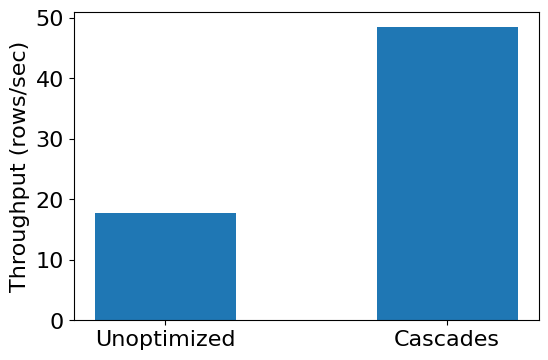

In [11]:

with open(osp.join(working_dir, "willump-adaptation", "result", f"{task_name}_{model_name}.json"), "w") as f:
  json_string = json.dumps(result_dict, indent=4)
  f.write(json_string)


plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars

bars = axes.bar(x, [num_rows / unopt_time_elapsed_total, num_rows / cascades_time_elapsed_total], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.savefig(osp.join(working_dir, "willump-adaptation", "result", f"{task_name}_{model_name}.jpg"))
